# Прогнозирование большого количества рядов

In [1]:
import os
os.sys.path = ['/home/kender/.virtualenvs/qc/lib/python2.7/site-packages'] + os.sys.path

In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import seaborn as sns
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [3]:
region_list = [1075, 1076, 1077, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1172, 1173, 1174, 1175, 1176, 1177,
               1178, 1179, 1180, 1181, 1182, 1183, 1184, 1221, 1222, 1223, 1224, 1225, 1227, 1228, 1229, 1230, 1231,
               1232, 1233, 1234, 1235, 1272, 1273, 1274, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287,
               1326, 1327, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1376, 1377, 1378, 1380, 1382, 1383,
               1384, 1385, 1386, 1387, 1388, 1389, 1390, 1426, 1431, 1434, 1435, 1436, 1437, 1438, 1439, 1441, 1442,
               1480, 1482, 1483, 1530, 1532, 1533, 1580, 1630, 1684, 1733, 1734, 1783, 2068, 2069, 2118, 2119, 2168]

In [4]:
region = pd.read_csv('regions.csv', delimiter=';')
value = [region[region.region == item].values[0] for item in region_list]
regions = pd.DataFrame(
    value,
    columns=['region', 'west', 'east', 'south', 'north'])

# 1. Подготовка данных.
Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!

Загрузим ранее посчитанные данные и уберём май 2016.

In [5]:
data = pd.read_csv('regions_counts_by_hours.csv', index_col=0)

In [6]:
data = data[data.datetime < '2016-05'].sort('datetime')

/srv/jupyterhub/py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


# 2. Стандартизируем столбцы
Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.

In [7]:
import numpy as np
sample = data.copy()

In [8]:
for item in region_list:
    item = str(item)
    selective_mean = sample[item].mean()
    selective_dispersion = sample[item].std()
    sample[item] = (sample[item] - selective_mean) / selective_dispersion

In [9]:
sample.head()

1075      1076      1077      1125      1126      1127      1128  \
0  0.534241  0.178268 -0.565290  0.271008  1.423365  0.941171  1.327459   
1  0.823251  1.005466 -0.582498  1.673565  2.292532  1.069110  0.407537   
2  0.796978  0.202960 -1.029900  1.083015  2.180052  1.104649  0.081851   
3 -0.726896 -0.525467 -1.150354 -0.098086  0.738257  0.919848  0.144702   
4 -0.937086 -1.068702 -1.253601 -0.319543 -0.355871 -0.110772 -0.198126   

       1129      1130      1131         ...               1684      1733  \
0  1.324730  1.906584  1.834661         ...          -0.883553 -0.571816   
1  0.529737  0.846772  1.255014         ...          -0.883553 -0.069227   
2  0.108003 -0.065844  0.095721         ...          -0.883553 -0.404286   
3 -0.168306 -0.276125  0.473165         ...          -0.883553 -0.571816   
4 -0.051966 -0.313975  0.190082         ...          -0.883553 -0.906875   

       1734      1783      2068      2069      2118      2119      2168  \
0 -1.047599 -1.251690 -0.786630 -0.681784 -0.821134 -0.855567  0.031375   
1 -1.325488 -1.275612 -1.423584 -1.171799 -1.125064 -1.089196 -0.930987   
2 -1.338721 -1.259664 -1.492444 -1.171799 -0.834348 -1.089196 -1.321133   
3 -1.312255 -1.251690 -1.475229 -1.171799 -1.468637 -1.128134 -1.451182   
4 -1.332105 -1.283586 -1.492444 -1.171799 -1.402566 -1.089196 -1.529211   

              datetime  
0  2016-01-01 00:00:00  
1  2016-01-01 01:00:00  
2  2016-01-01 02:00:00  
3  2016-01-01 03:00:00  
4  2016-01-01 04:00:00  

[5 rows x 103 columns]

# 3. Кластеризуем географические зоны
Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.

In [10]:
import sklearn.cluster as cluster
from collections import Counter

In [11]:
X = sample.copy()
X.drop('datetime', axis=1, inplace=True)

In [18]:
cl = cluster.KMeans(n_clusters=12, max_iter=1000000000)
cl.fit(X.T.values[0:102, 0:2904])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000000000,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [19]:
Counter(cl.labels_)

Counter({0: 7,
         1: 19,
         2: 5,
         3: 10,
         4: 5,
         5: 10,
         6: 8,
         7: 6,
         8: 8,
         9: 4,
         10: 11,
         11: 9})

In [20]:
cl.labels_

array([11, 11,  1,  3,  3,  5,  5,  8,  8,  5, 11,  4,  4,  4,  4,  8,  8,
        8,  3,  3,  1,  5,  5,  1,  0,  0,  0,  5,  4,  8,  8,  5,  5,  3,
        3,  3, 11, 11,  0,  0,  0,  5,  1,  1,  3,  3, 11, 11,  1,  1,  1,
        8,  6,  1,  1,  1, 11,  1,  1,  1, 11,  5,  6,  6,  6,  0,  3,  1,
        1,  1,  1, 10, 10, 10, 10,  6,  7,  1, 10, 10, 10, 10, 10, 10, 10,
        7,  7,  7,  7,  6,  6,  7,  6,  9,  9,  9,  9,  2,  2,  2,  2,  2], dtype=int32)

Вроде, неплохое распределение кластеров по группам

In [22]:
clusters = defaultdict(set)
for key, value in zip(cl.labels_, X.axes[1]):
    clusters[key].add(value)
clusters

defaultdict(set,
            {0: {'1221', '1222', '1223', '1272', '1273', '1274', '1380'},
             1: {'1077',
              '1181',
              '1184',
              '1279',
              '1280',
              '1285',
              '1286',
              '1287',
              '1331',
              '1332',
              '1333',
              '1335',
              '1336',
              '1337',
              '1383',
              '1384',
              '1385',
              '1386',
              '1434'},
             2: {'2068', '2069', '2118', '2119', '2168'},
             3: {'1125',
              '1126',
              '1179',
              '1180',
              '1231',
              '1232',
              '1233',
              '1281',
              '1282',
              '1382'},
             4: {'1172', '1173', '1174', '1175', '1225'},
             5: {'1127',
              '1128',
              '1131',
              '1182',
              '1183',
              '1224',
            

И судя по распределению регионов по кластерам тоже.

# 4. В каждом кластере выберите наиболее типичный ряд
Например, это может быть ряд, соответствующий центру кластера.

Выберем наиболее типичным рядом внутри кластера тот, у которого корреляция с остальными рядами внутри кластера больше:

In [25]:
rows = {data[list(clusters[_])].corr().mean().argmax(): _ for _ in xrange(12)}

In [26]:
rows

{'1174': 4,
 '1177': 8,
 '1222': 0,
 '1229': 5,
 '1233': 3,
 '1283': 11,
 '1333': 1,
 '1376': 6,
 '1387': 10,
 '1530': 7,
 '1783': 9,
 '2118': 2}

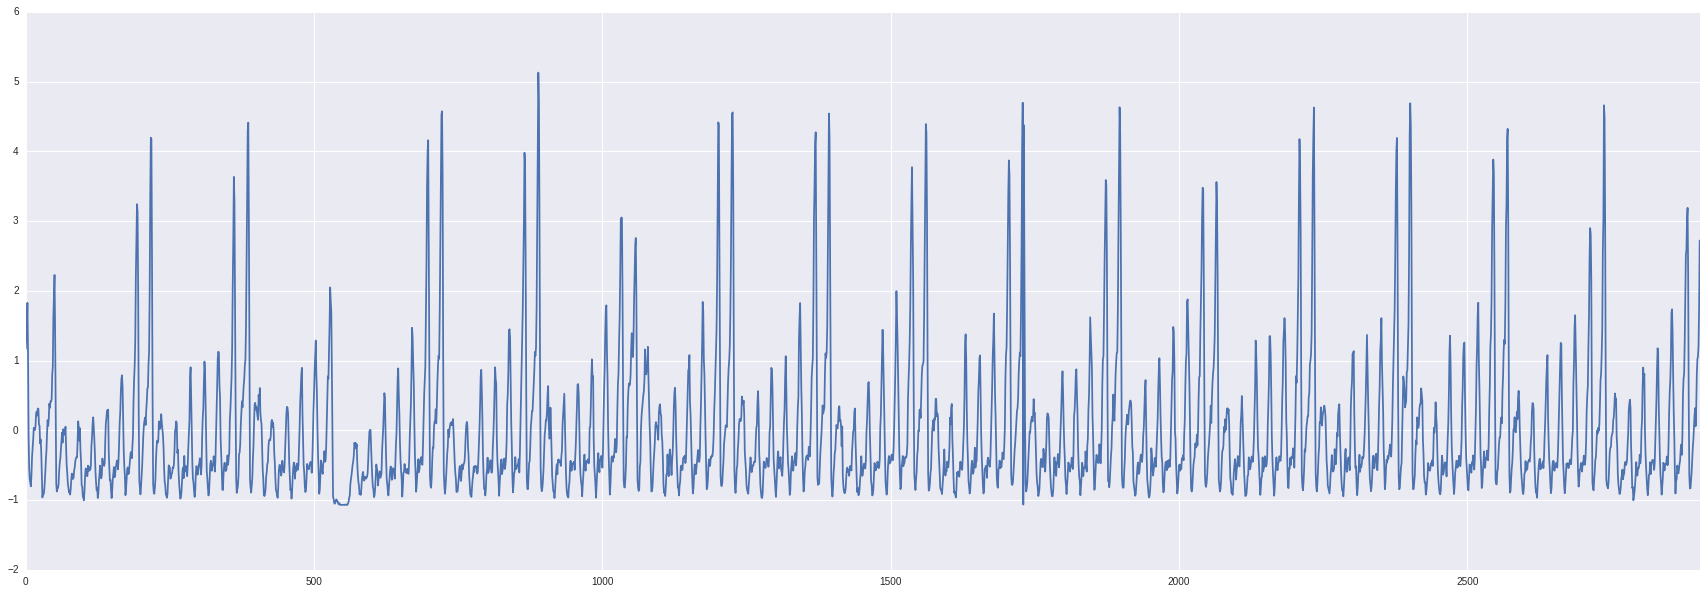

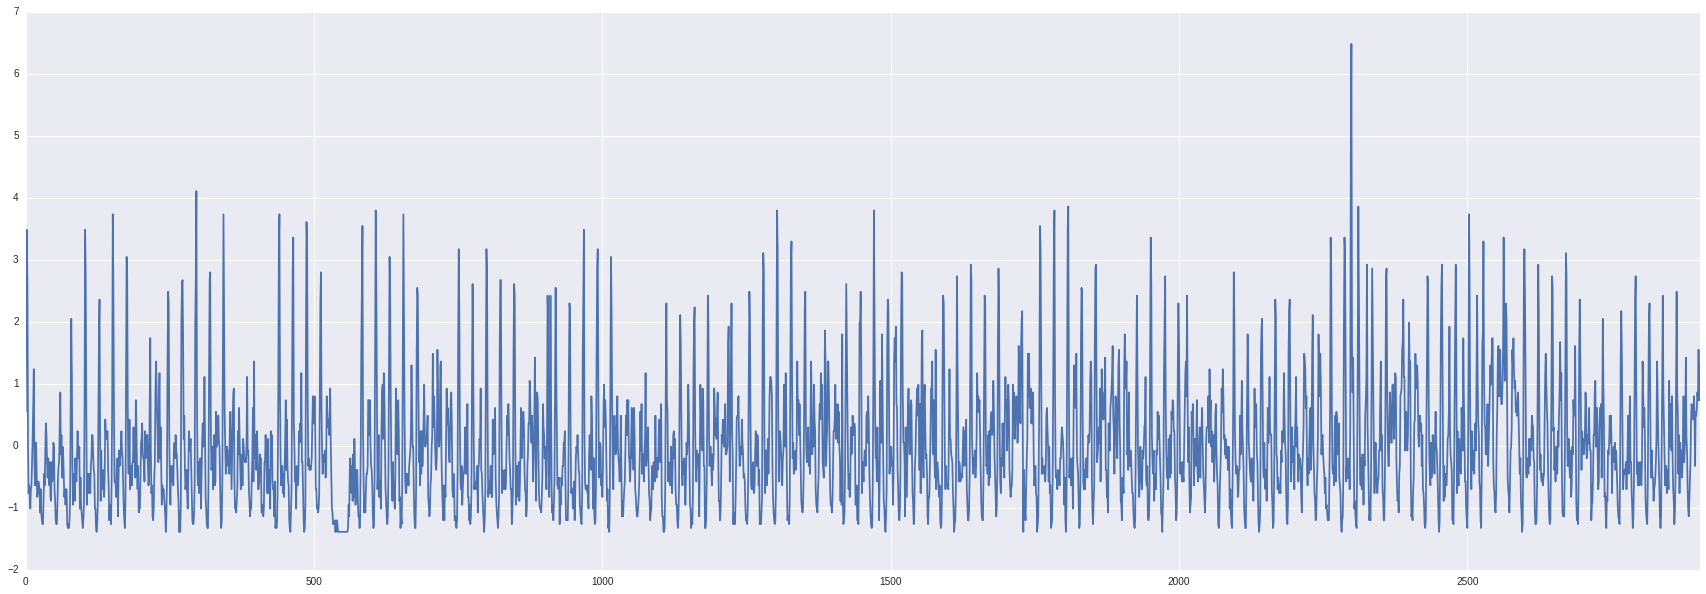

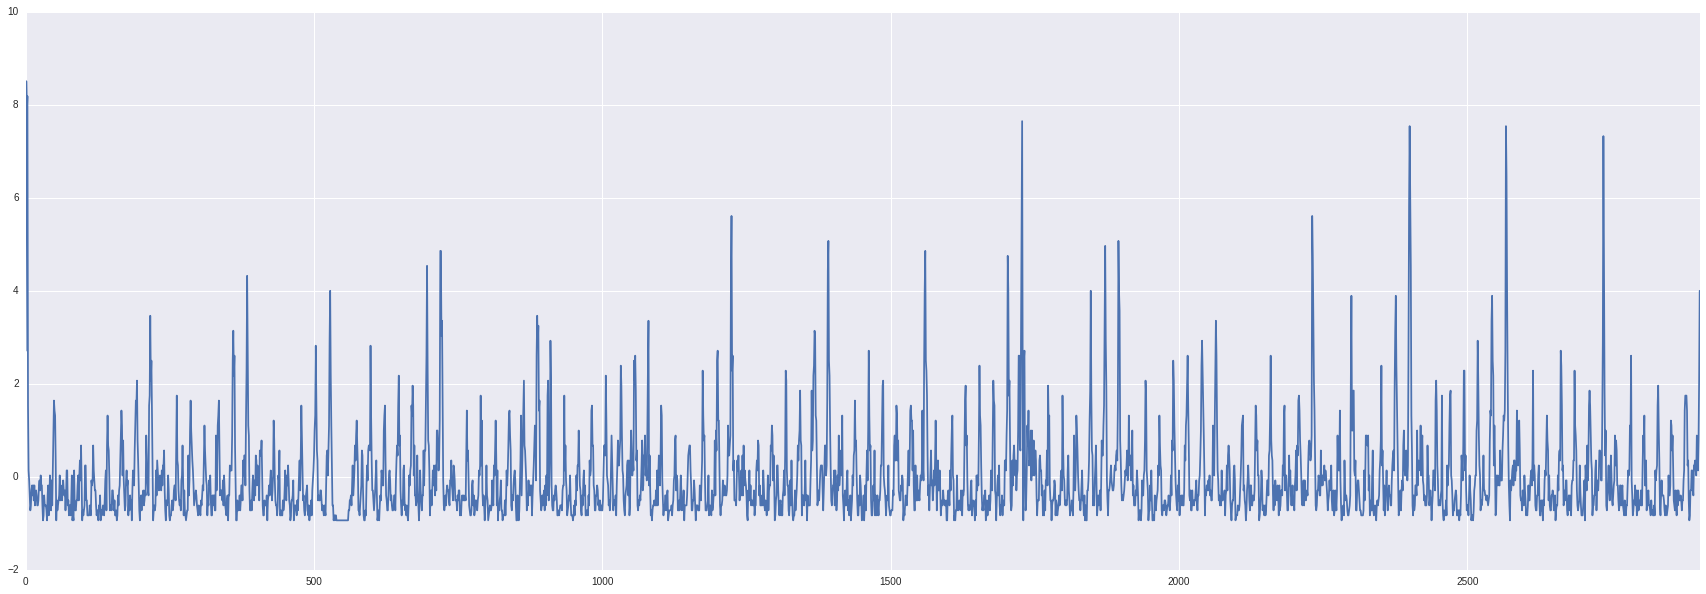

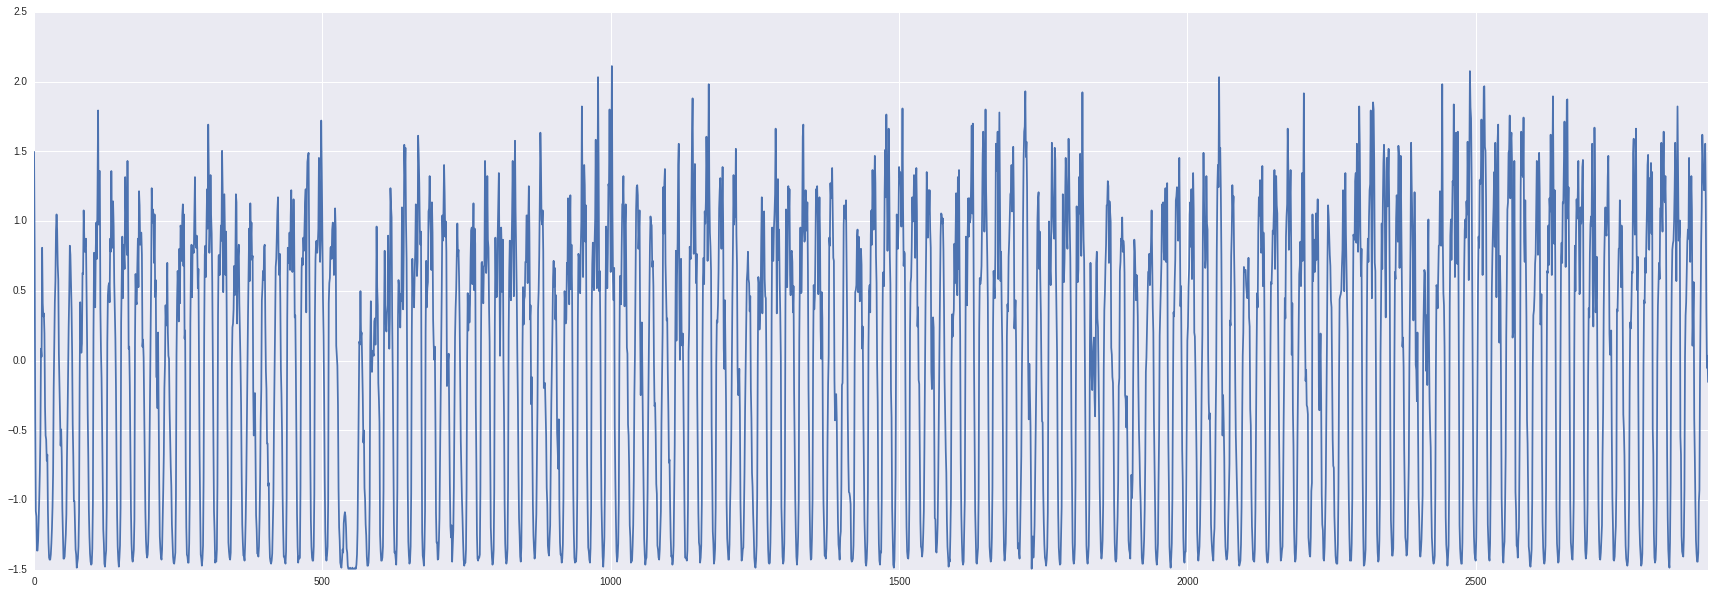

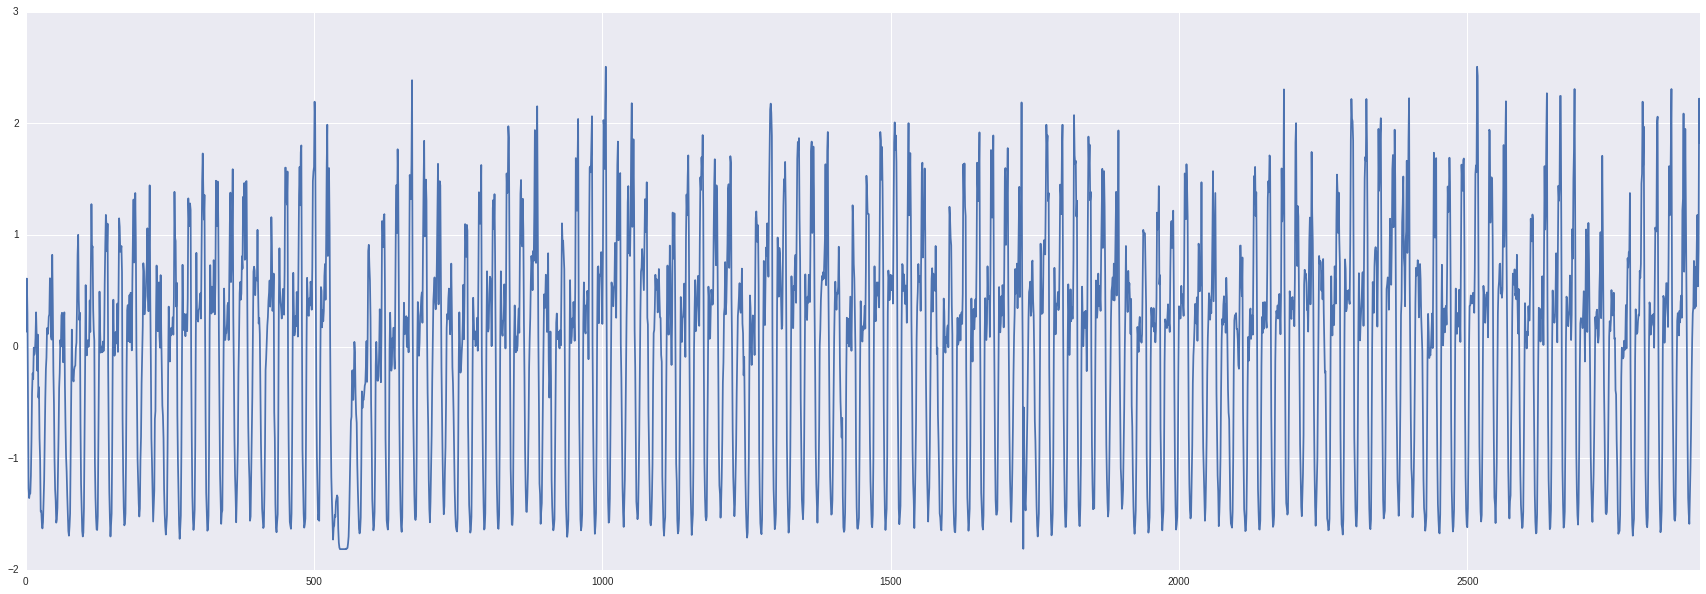

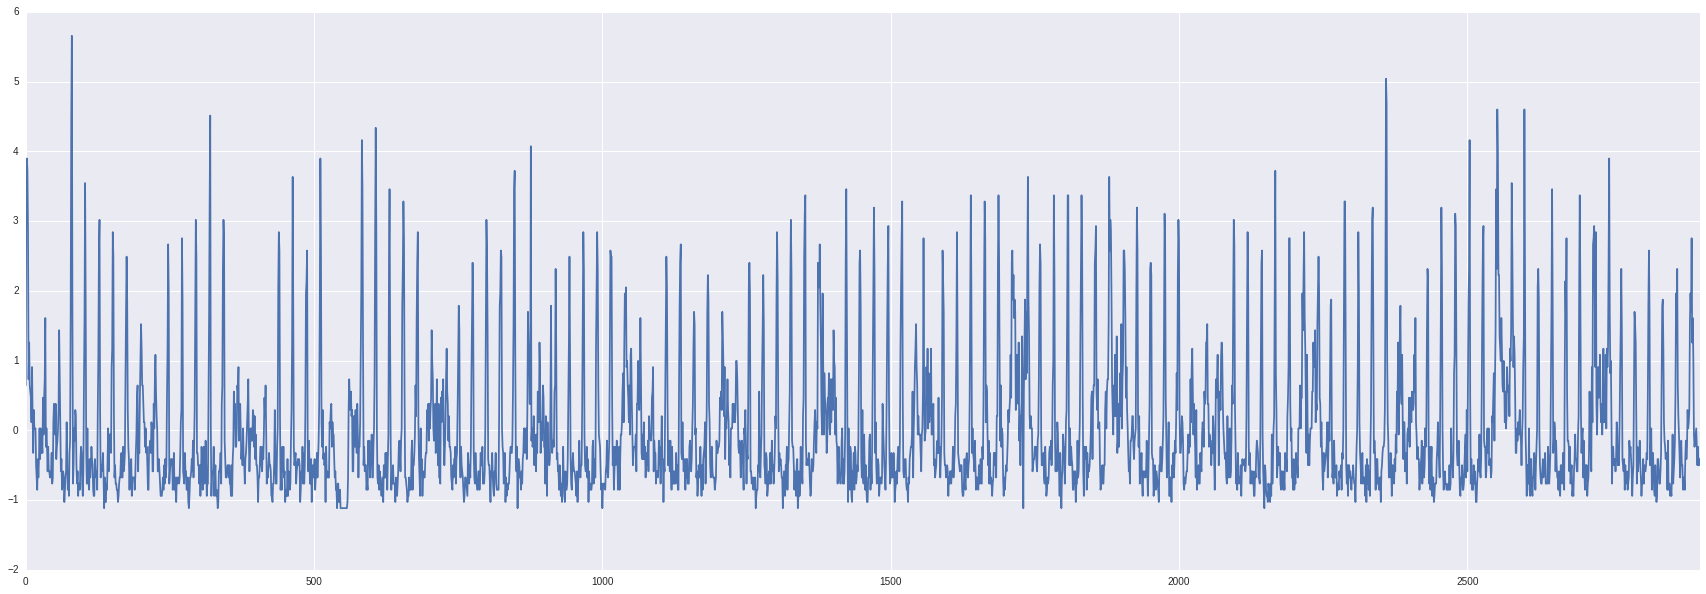

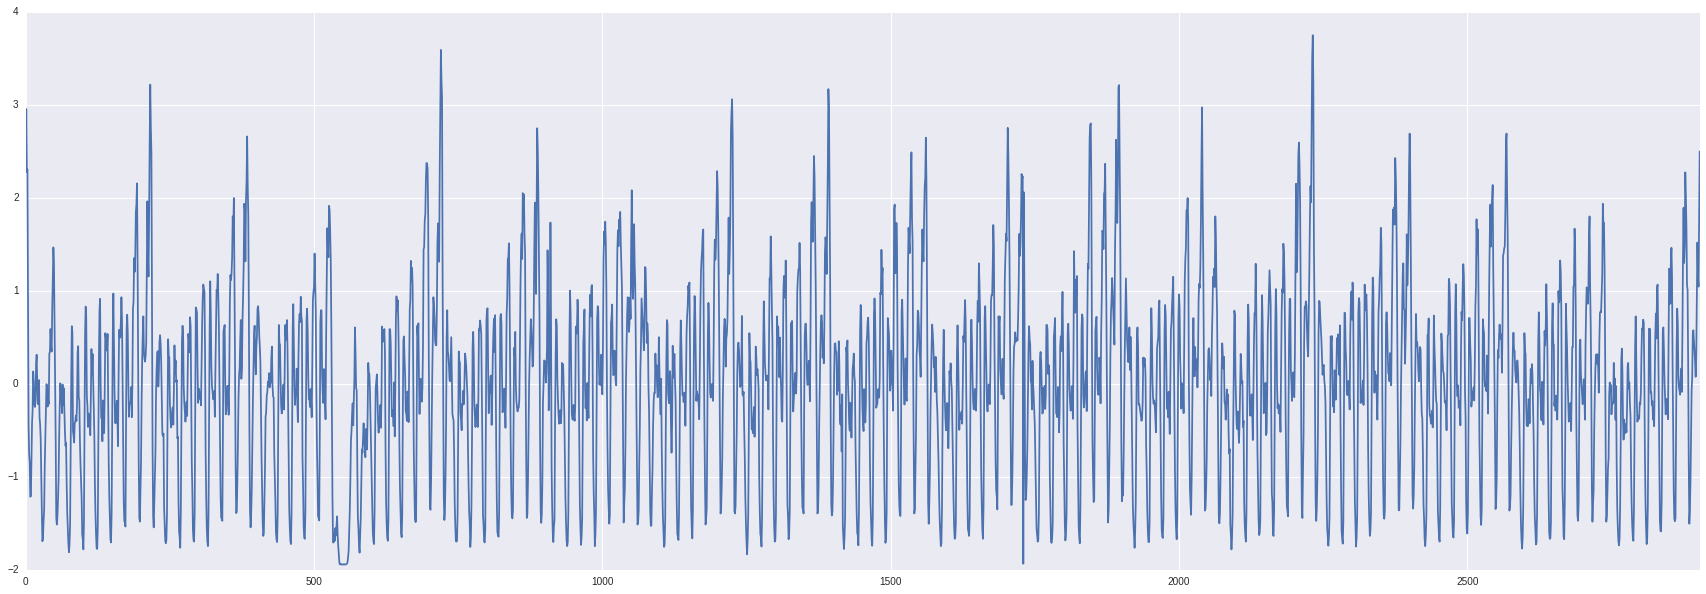

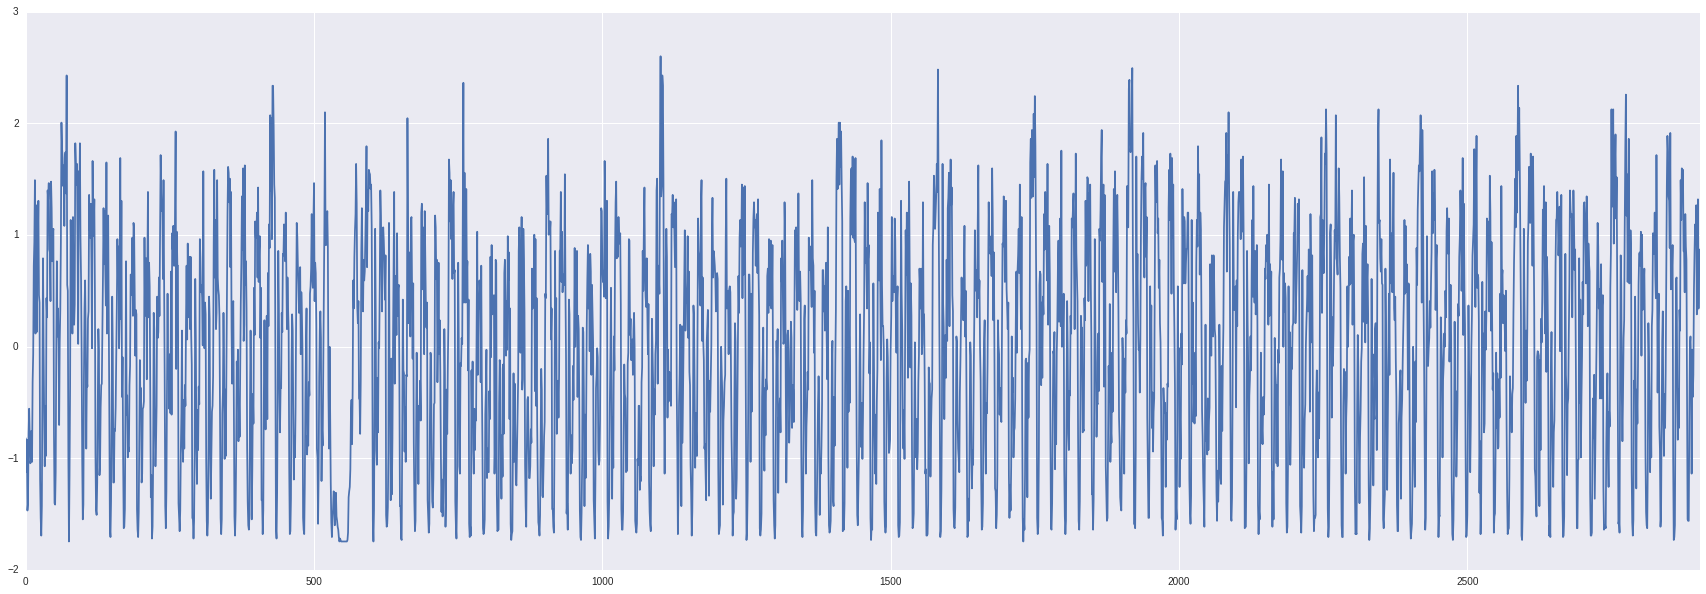

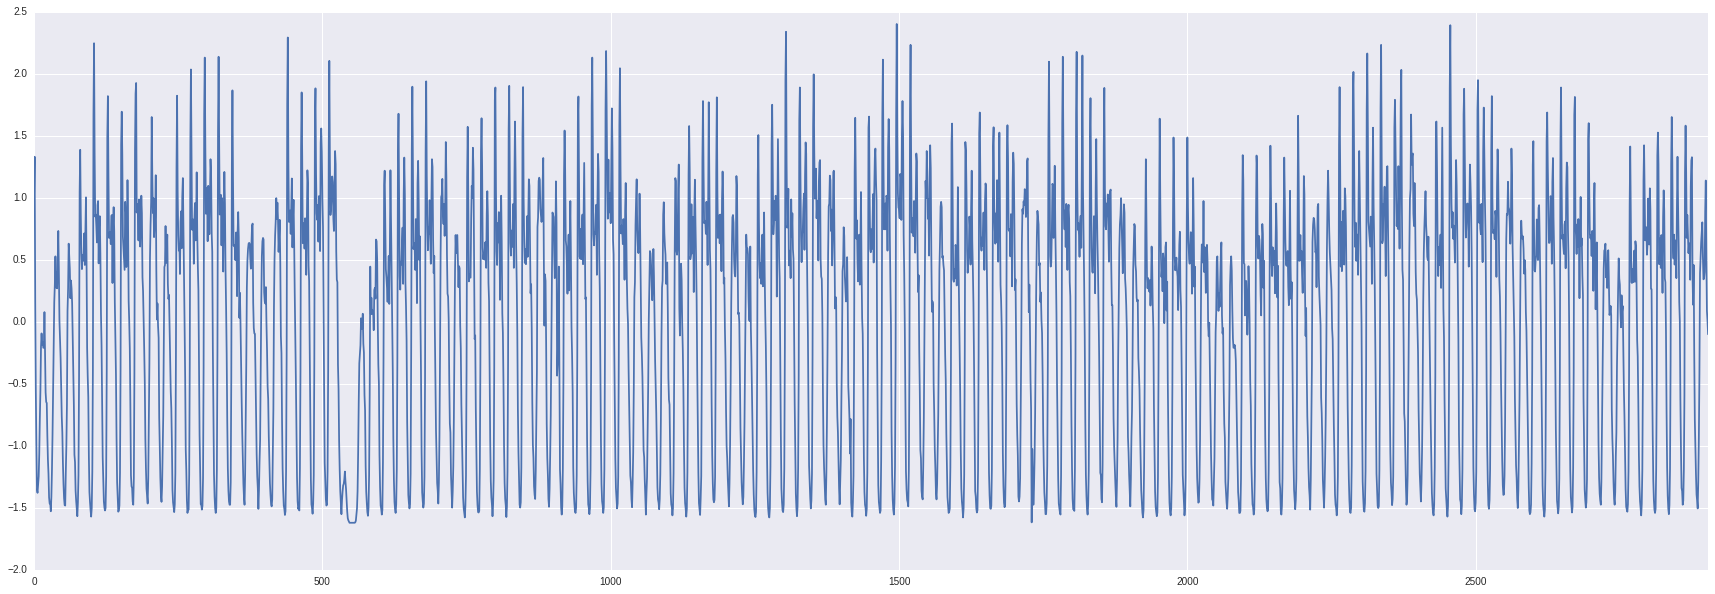

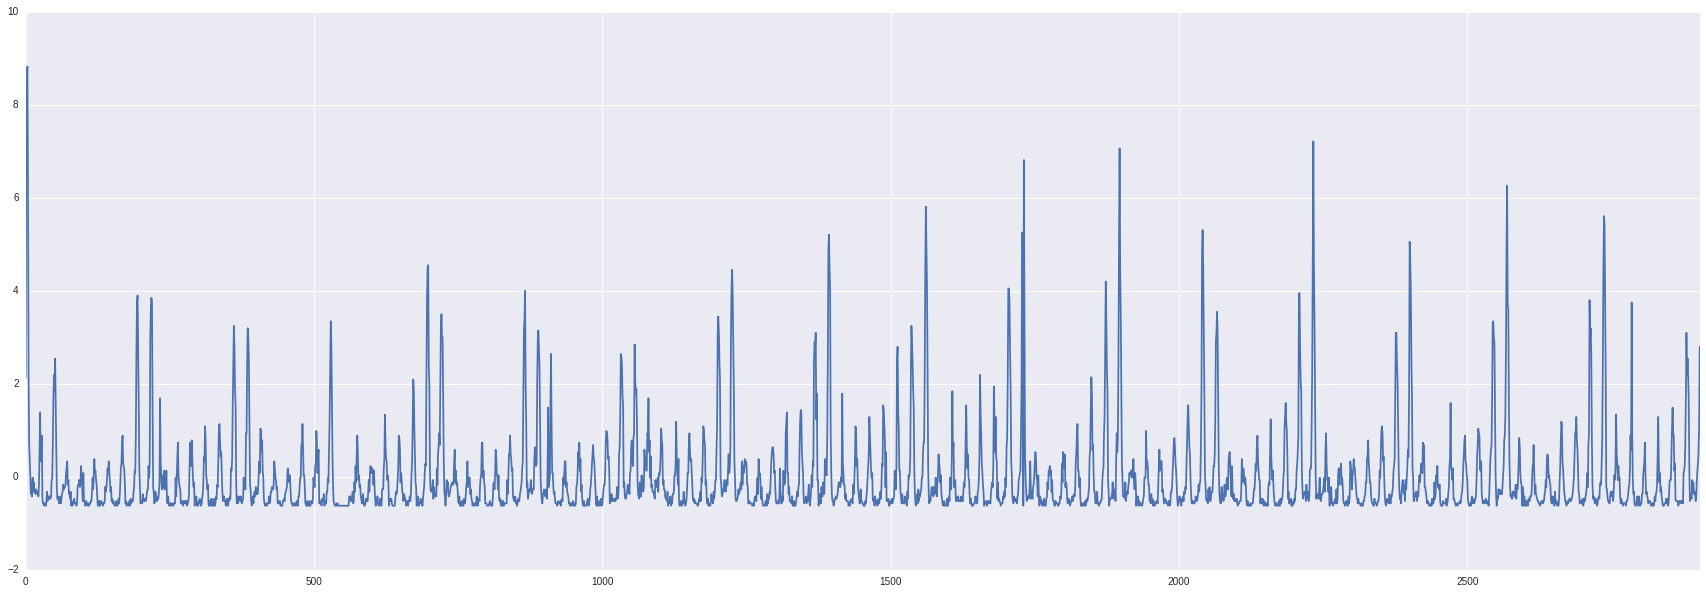

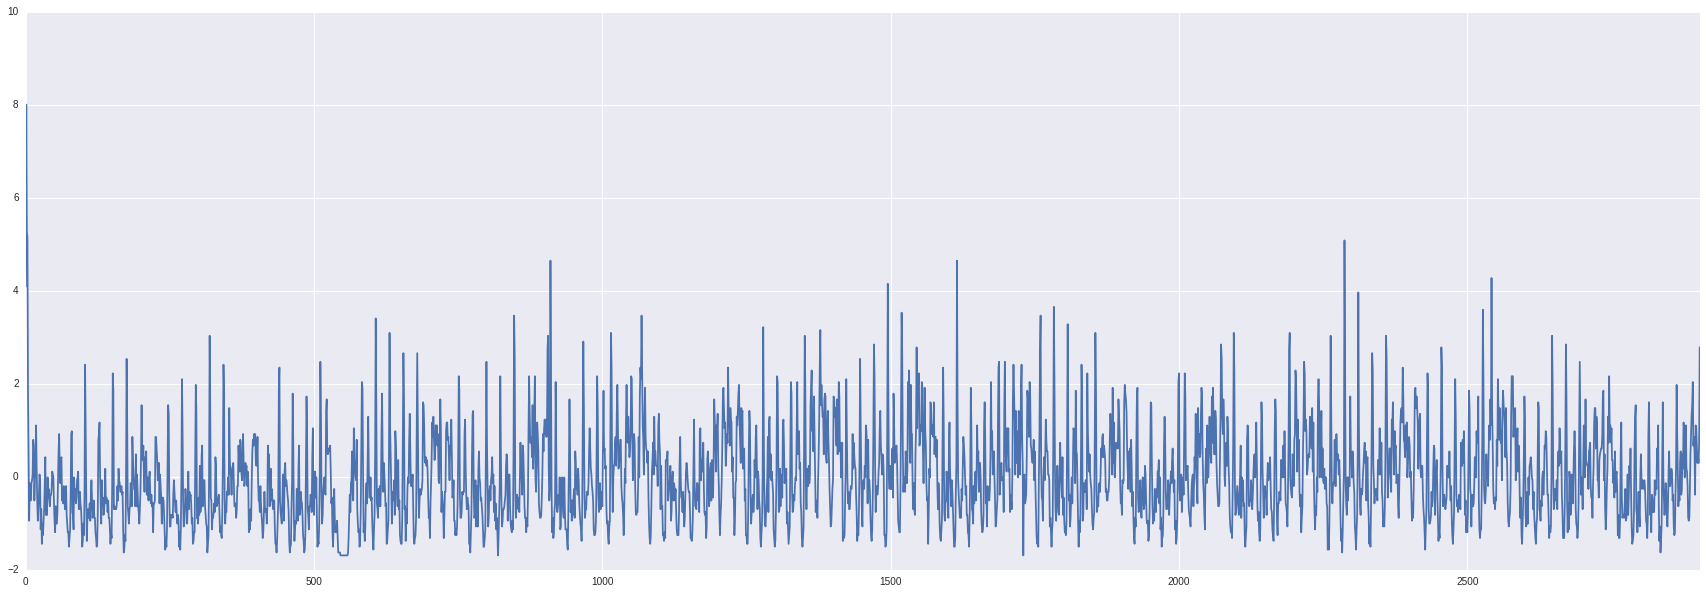

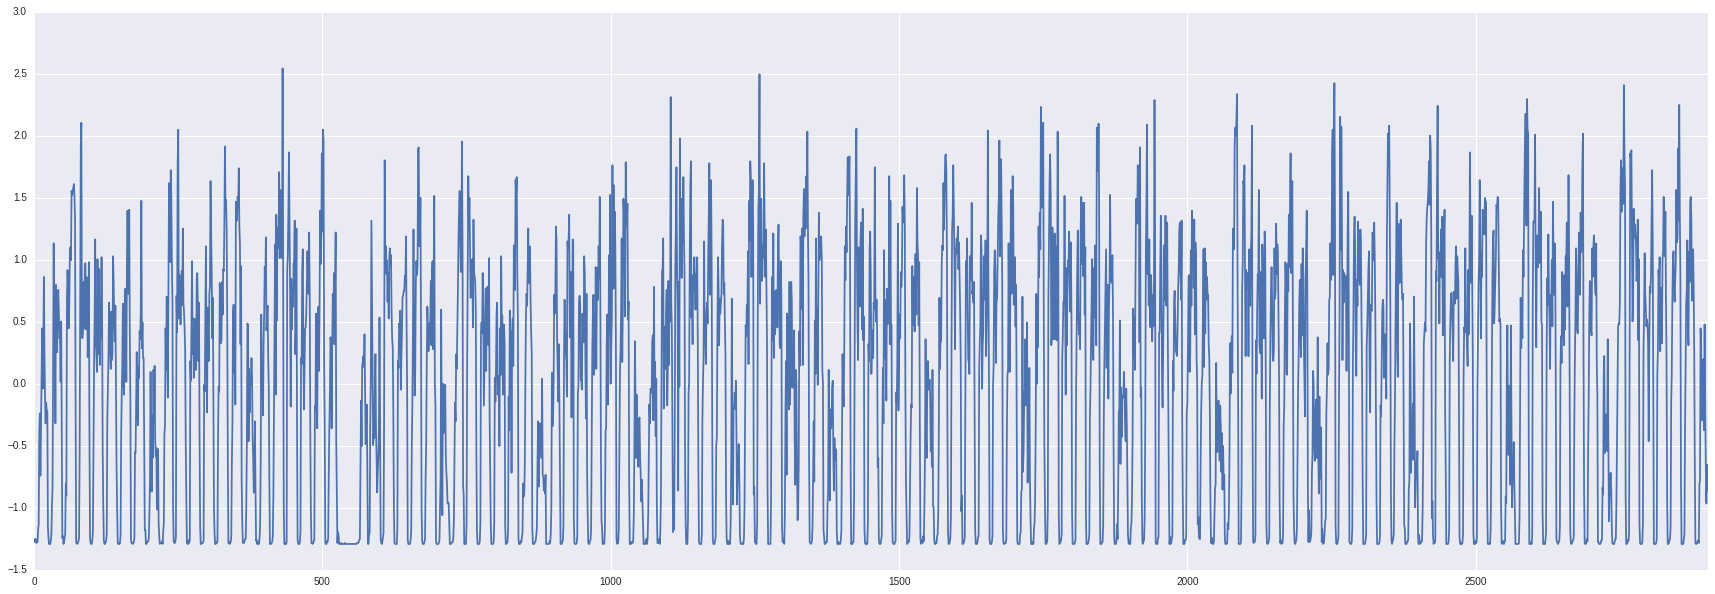

In [27]:
for item in rows:
    plt.figure(figsize(30,10))
    sample[item].plot()

# 5. Подберите на исходных рядах оптимальную структуру моделей
Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p,d,q,P,D,Q — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016!

In [29]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [30]:
data.index = data.datetime
data.drop('datetime', axis=1, inplace=True)

In [31]:
def get_factors(count):
    list_factors = list()
    for index in xrange(1, count + 1):
        factors = dict()
        for i in xrange(1, 6):
            factors['week_s_{}'.format(i)] = sin(i * index * 2 * pi / 168)
            factors['week_c_{}'.format(i)] = cos(i * index * 2 * pi / 168)
        list_factors.append(factors)
    return pd.DataFrame(list_factors)

Найдём остатки каждого из выбранных рядов

In [32]:
factors = get_factors(data.shape[0])
diffs = pd.DataFrame(columns=rows)
for row in rows:
    regr = LinearRegression()
    regr.fit(factors, data[row])
    value = factors * regr.coef_
    result = value.week_c_1 + value.week_c_2 + value.week_c_3 + value.week_c_4 + value.week_c_5 \
       + value.week_s_1 + value.week_s_2 + value.week_s_3 + value.week_s_4 + value.week_s_5 + regr.intercept_
    diffs[row] = data[row].values - result

Графики остатков для выбранных рядов

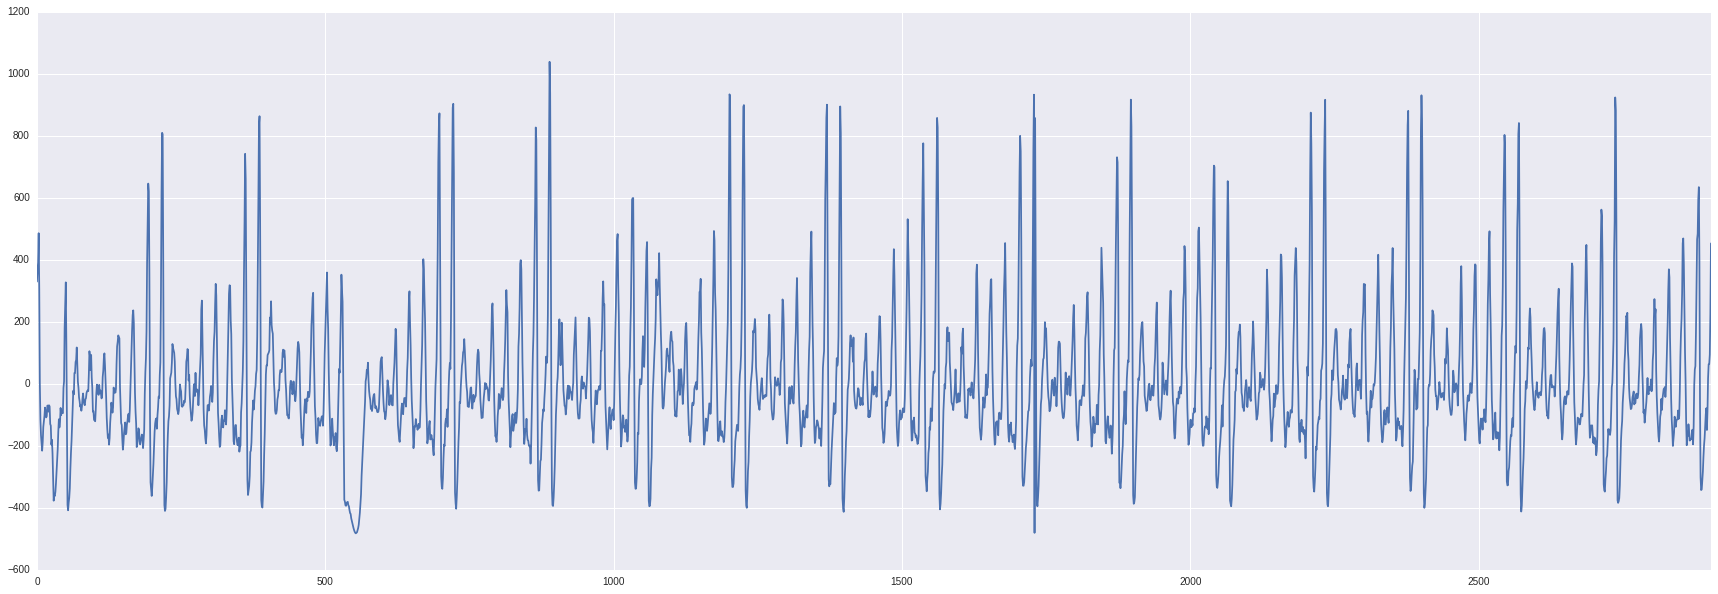

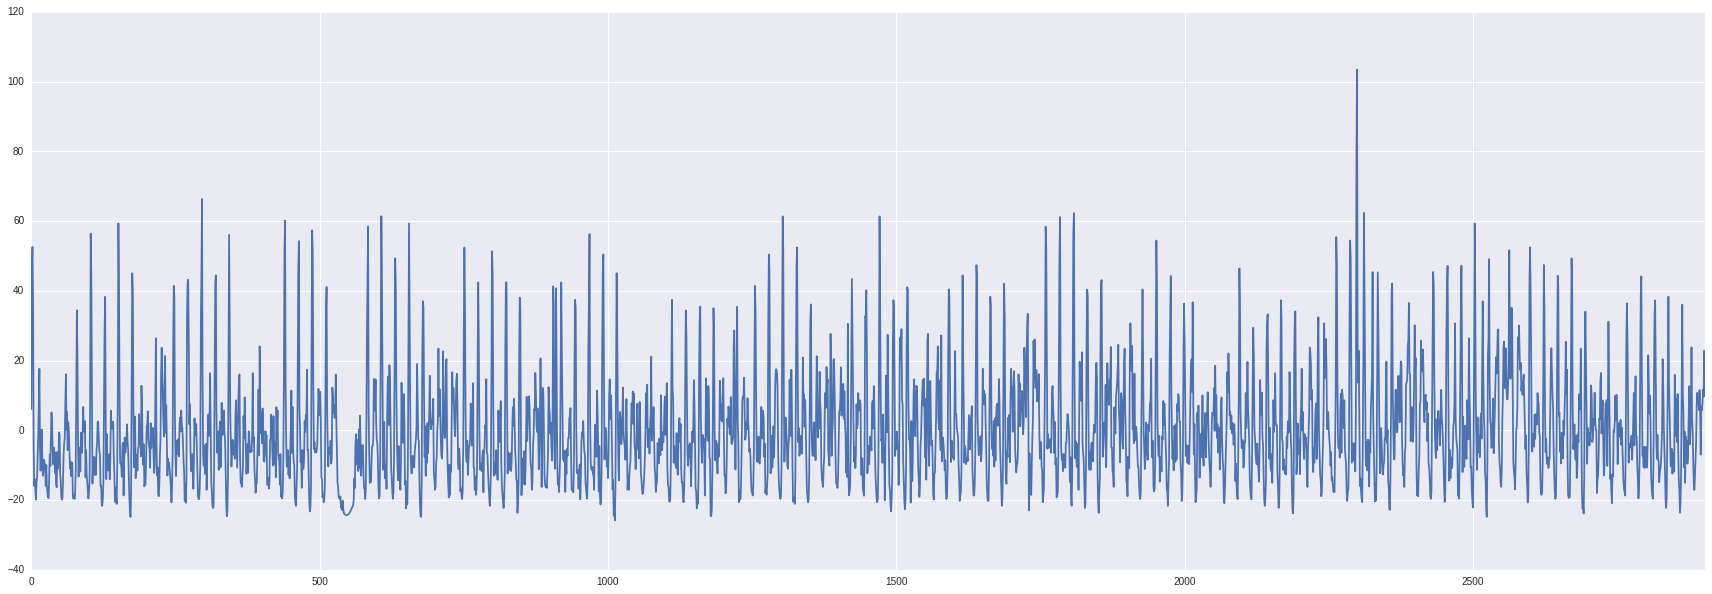

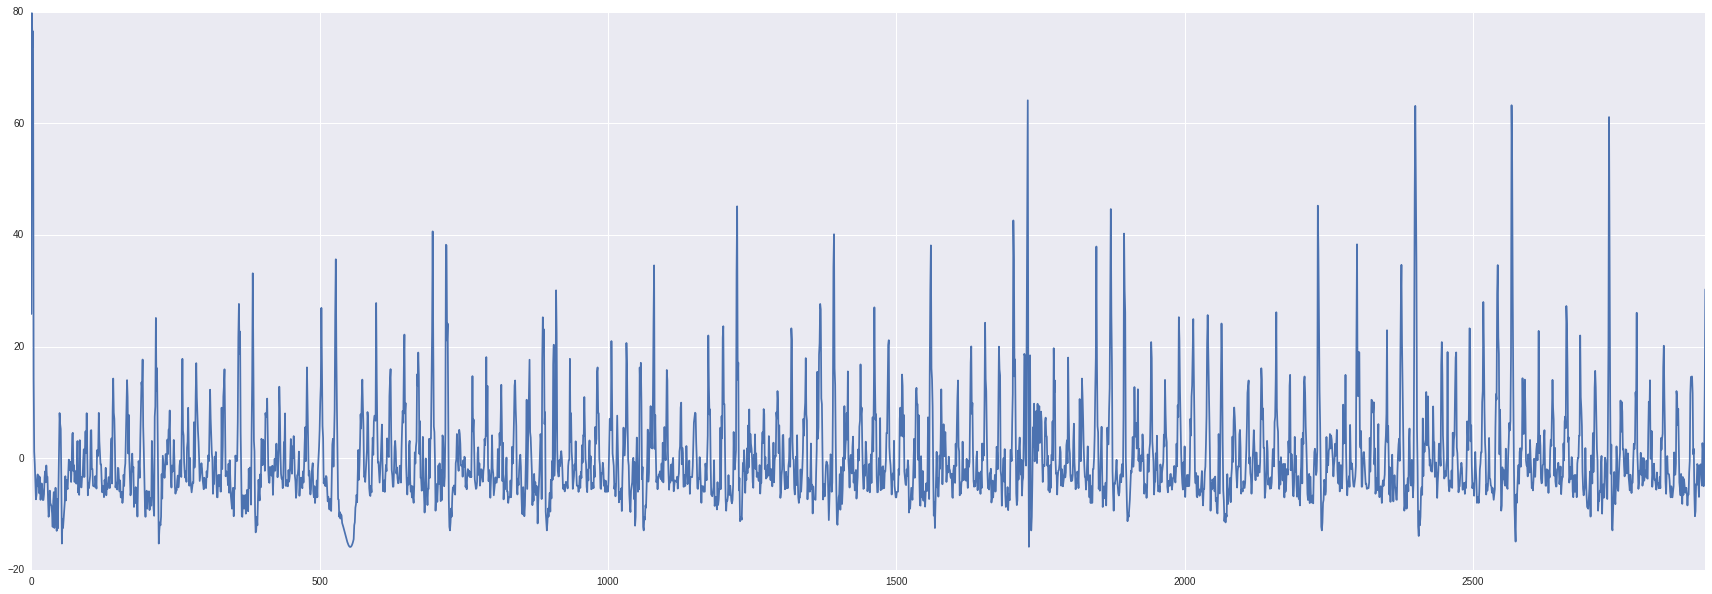

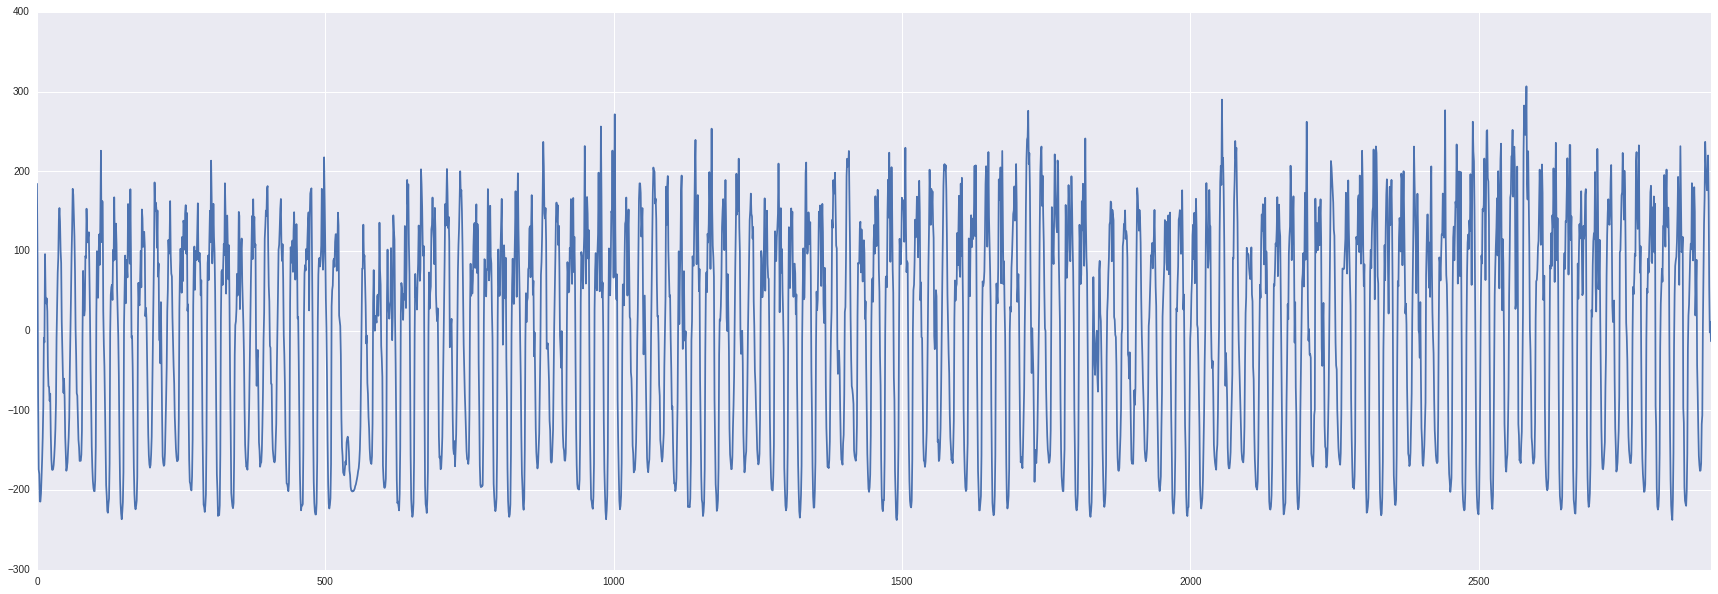

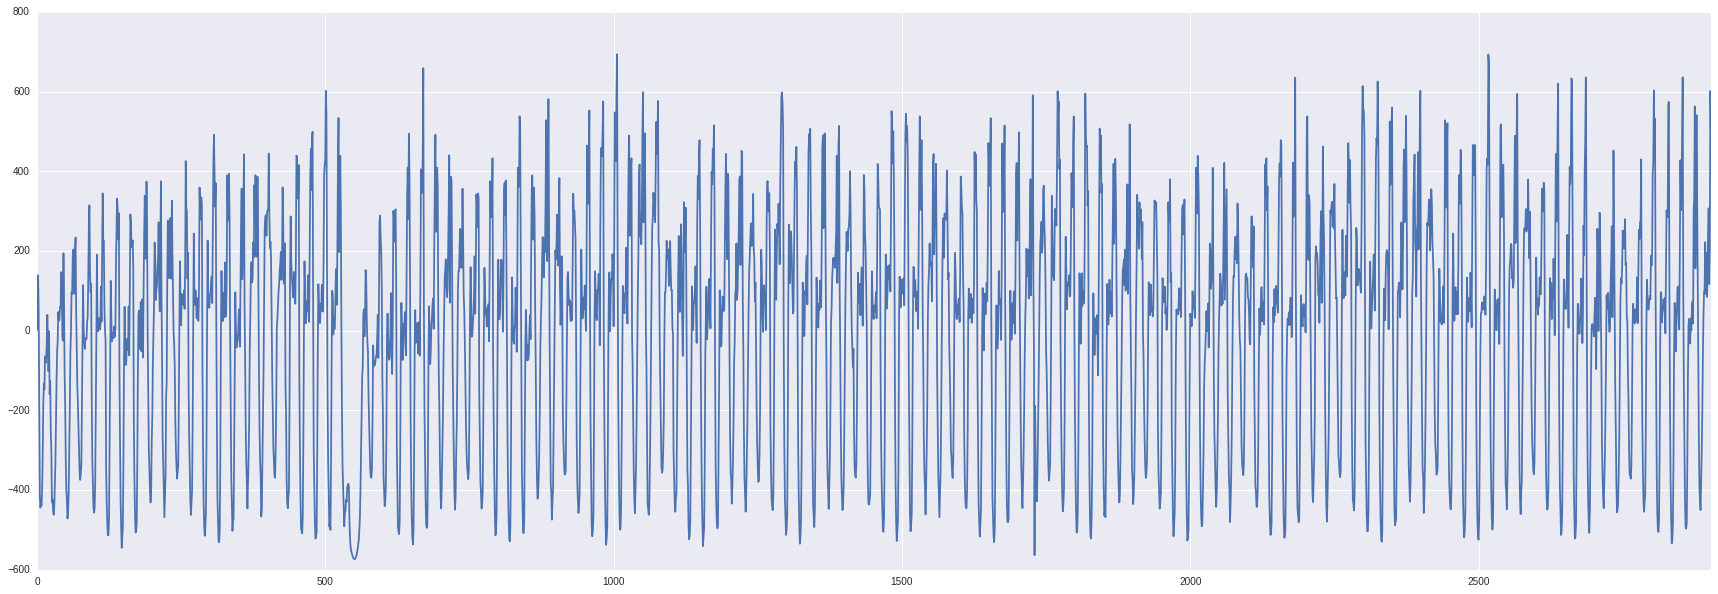

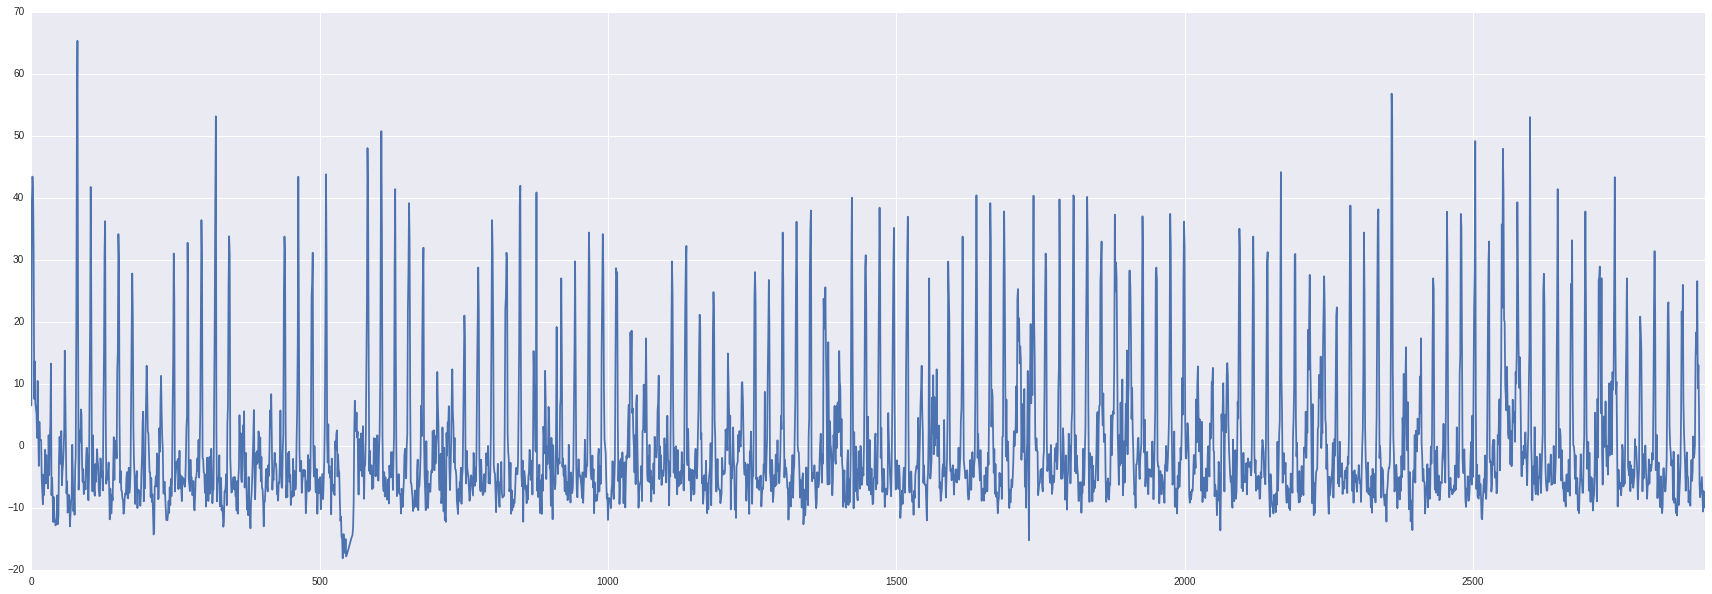

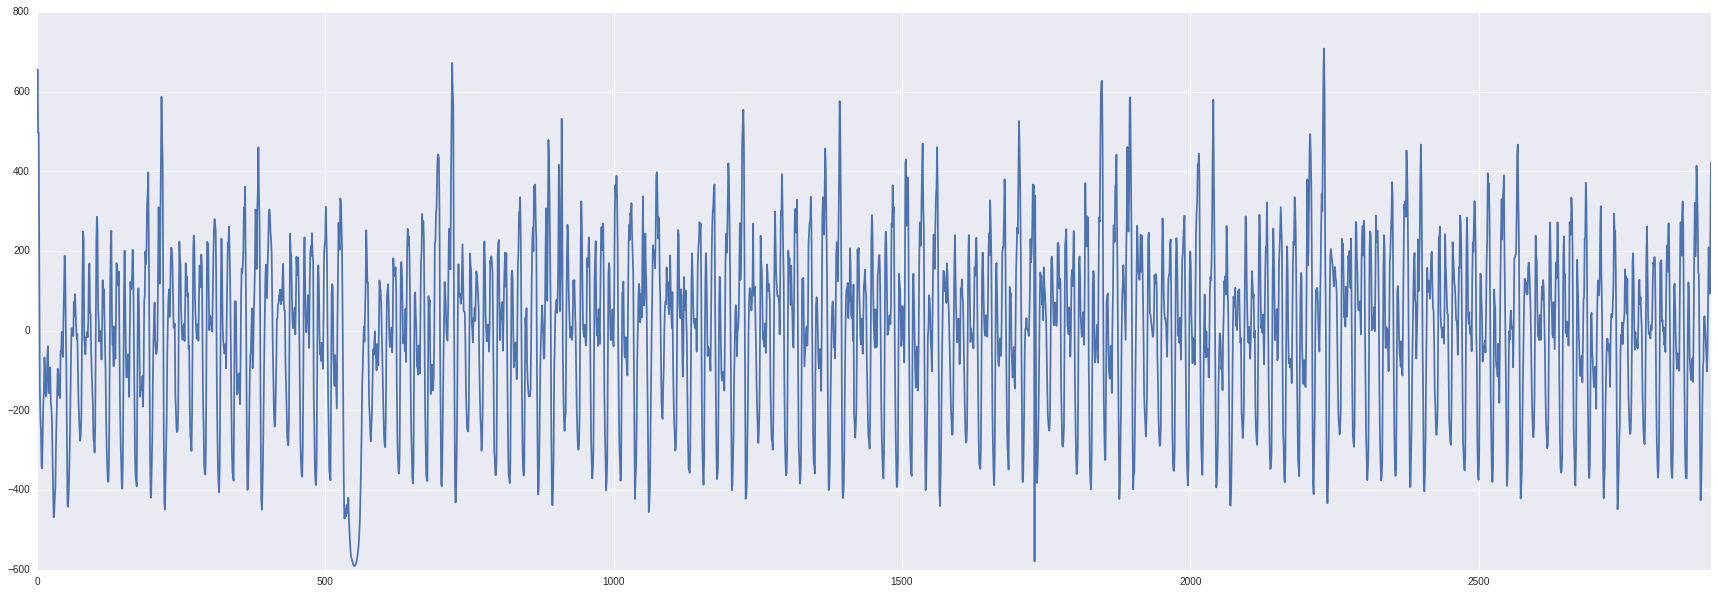

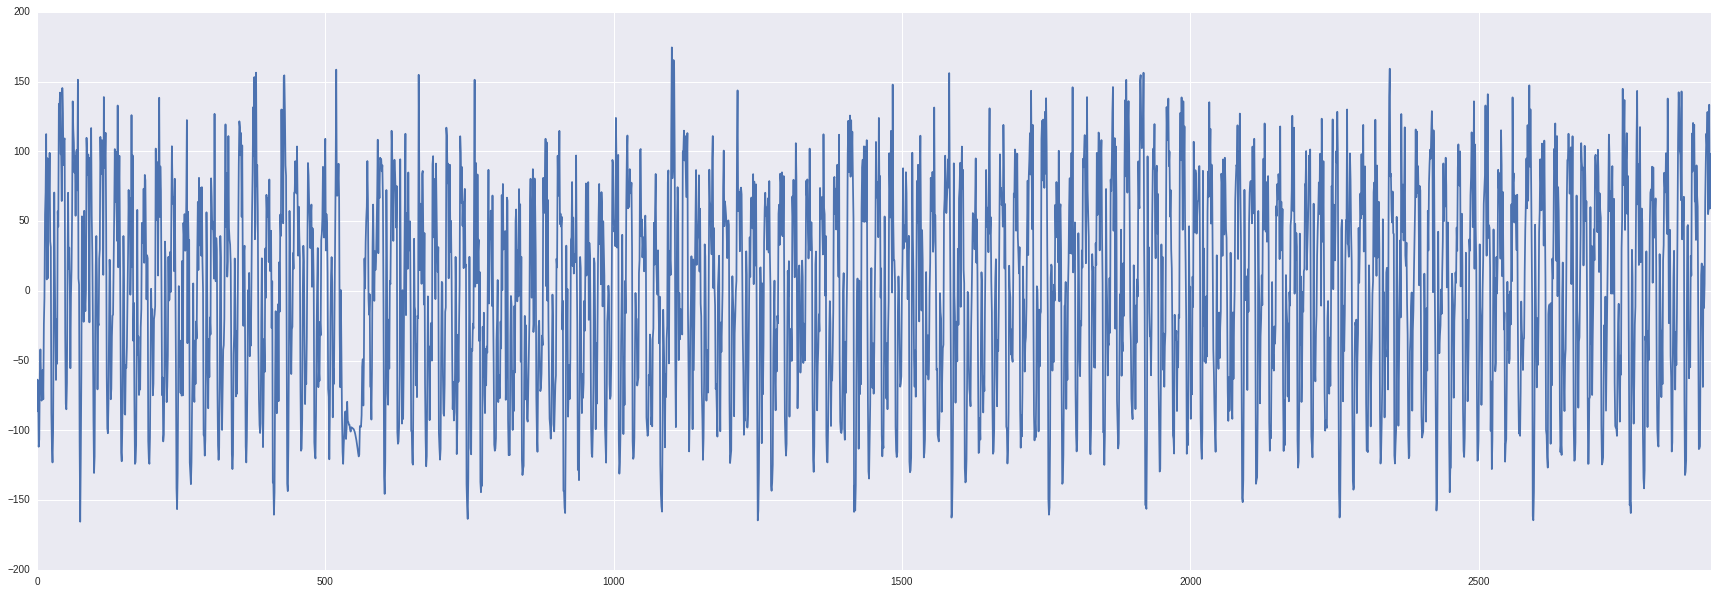

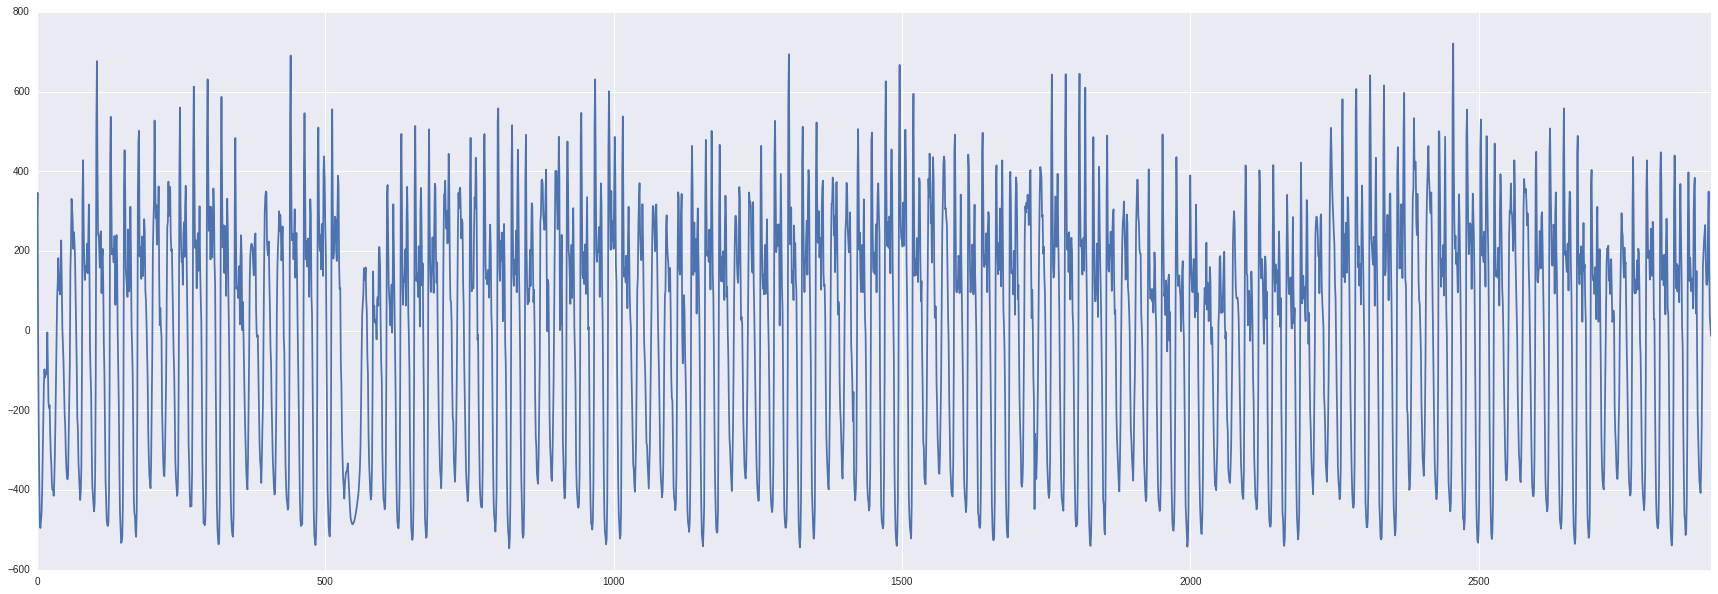

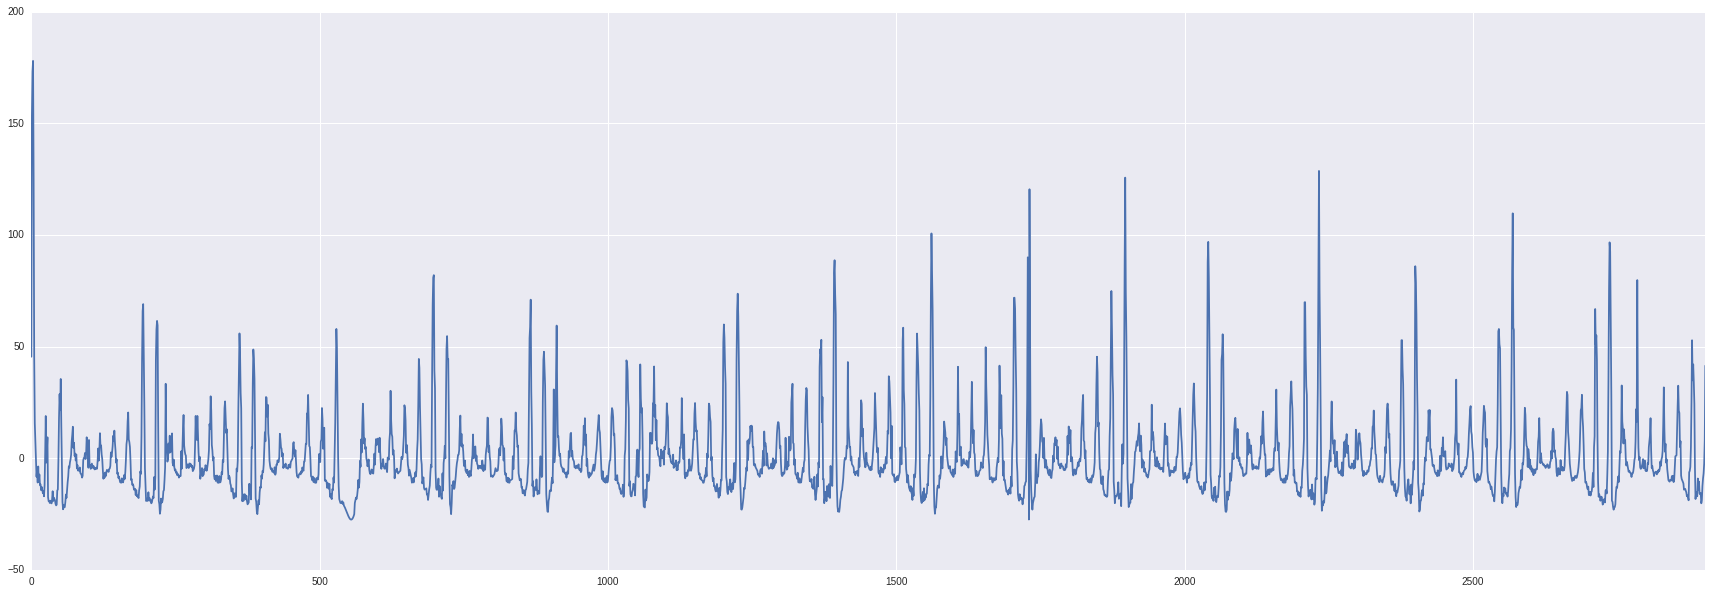

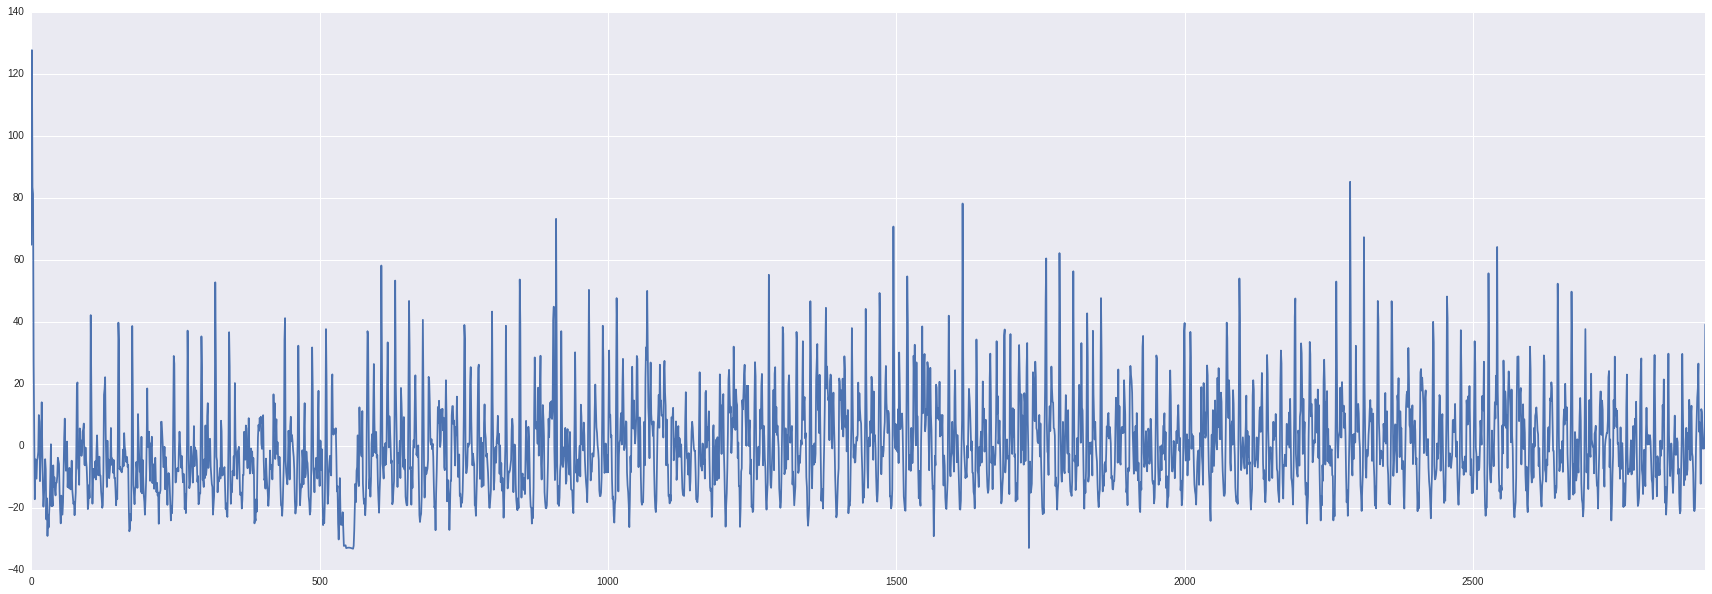

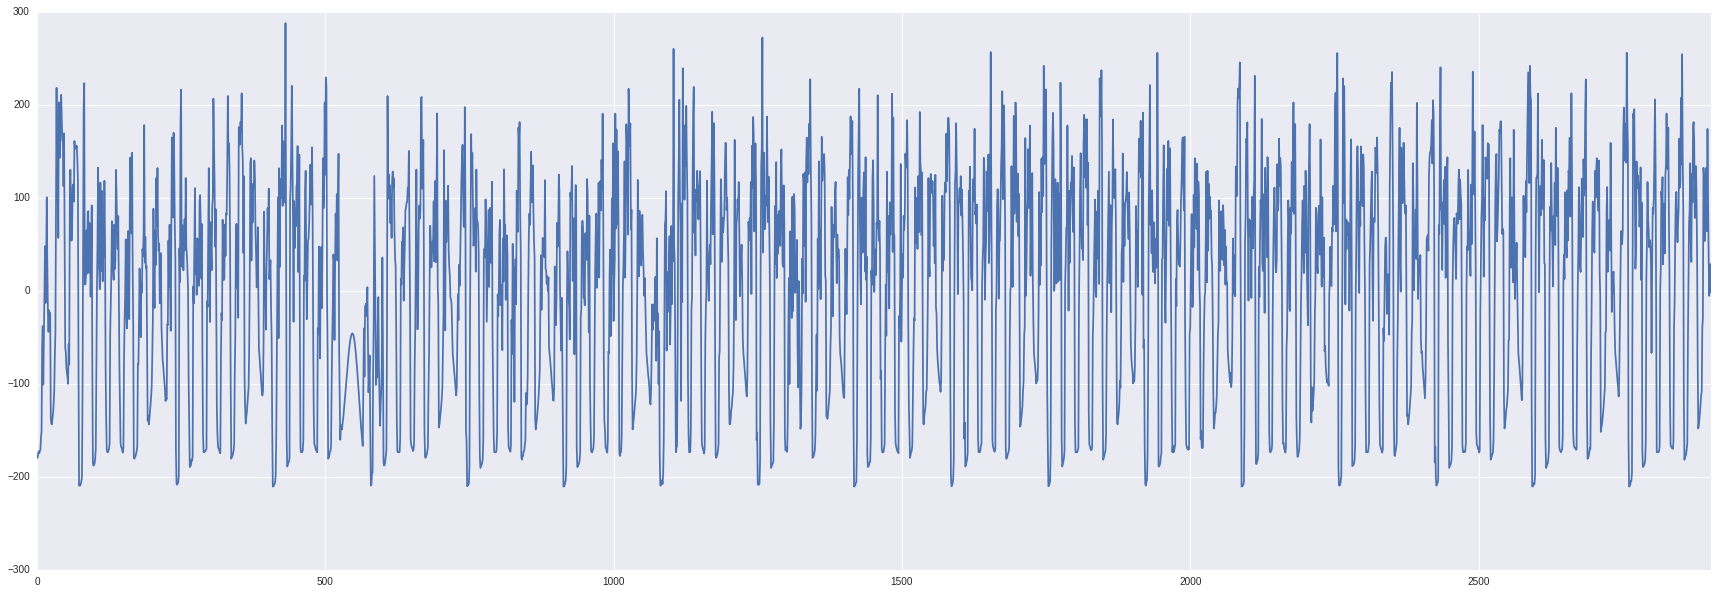

In [35]:
for item in rows:
    plt.figure(figsize(30,10))
    diffs[item].plot()

Построим графики acf/pacf для остатков дифференцированных по дням и часам

1177


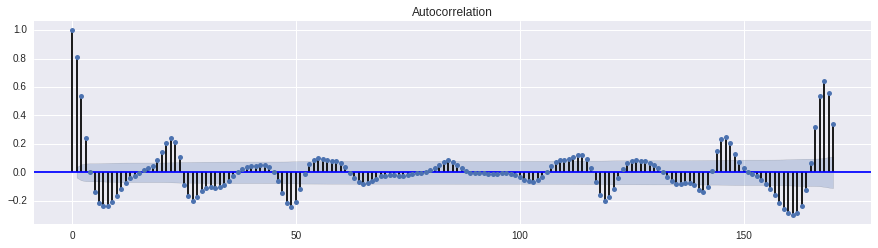

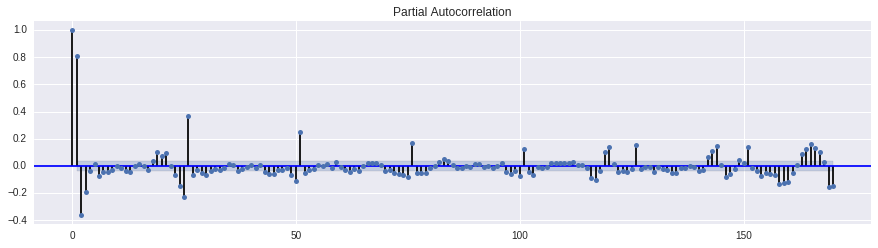

1174


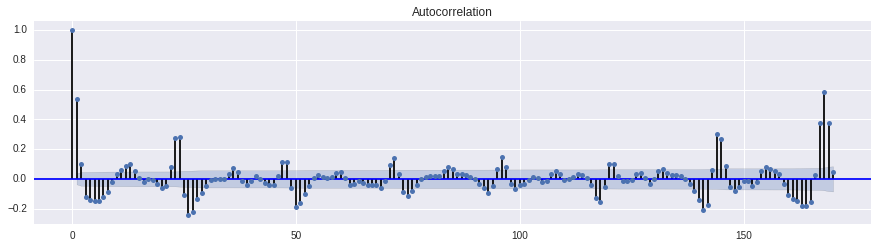

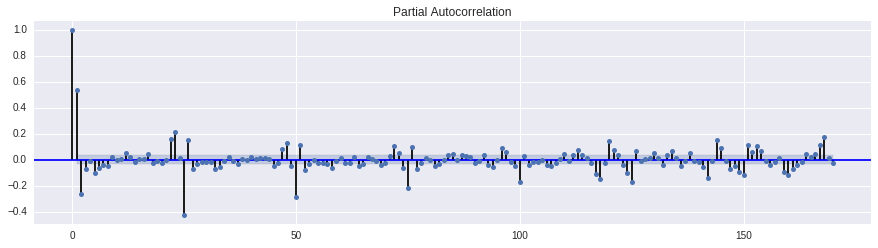

1222


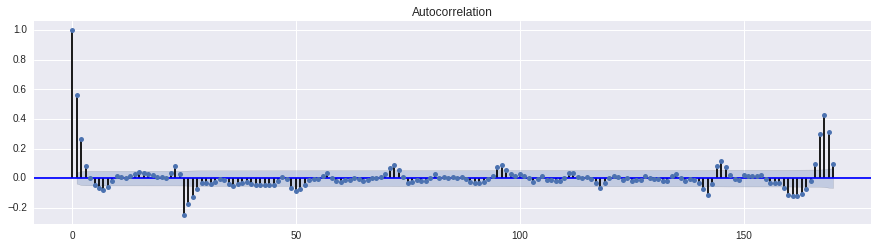

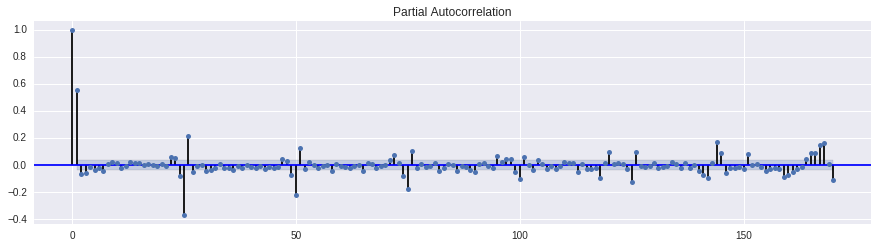

1283


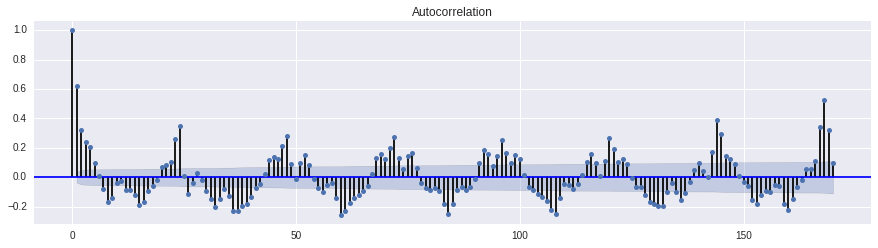

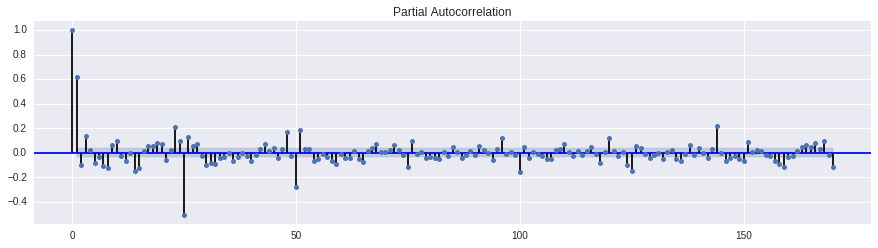

1233


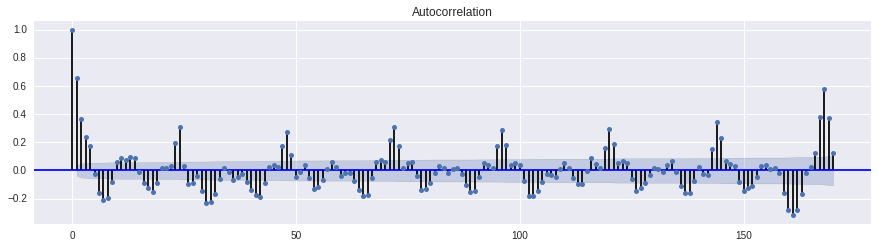

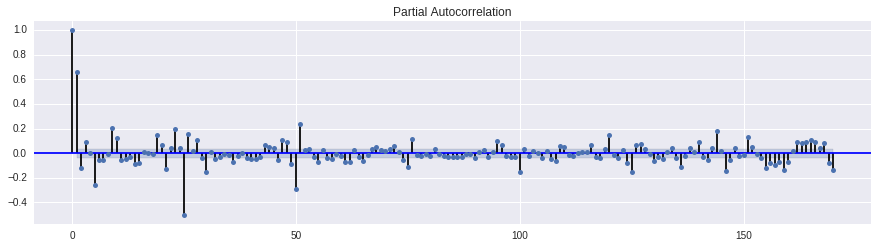

1530


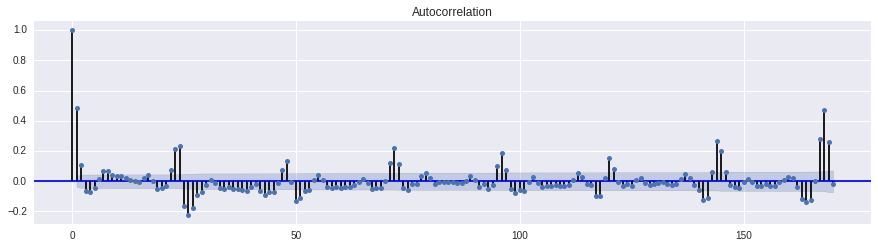

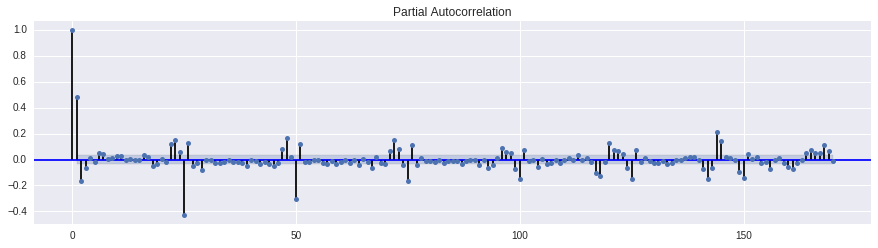

1229


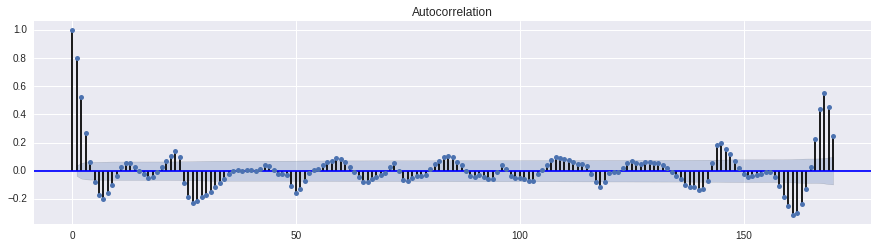

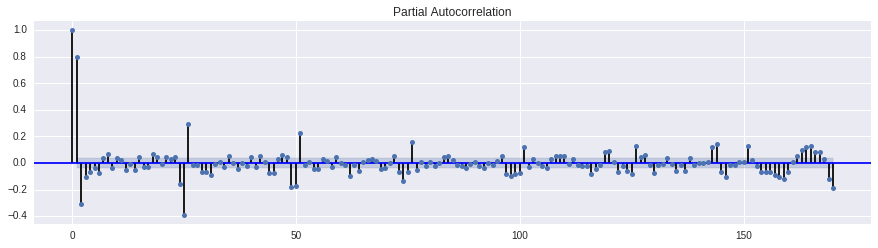

2118


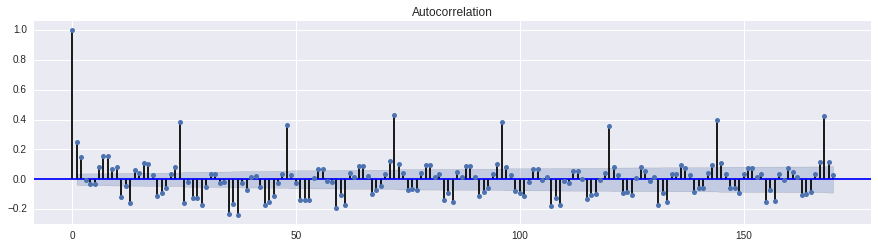

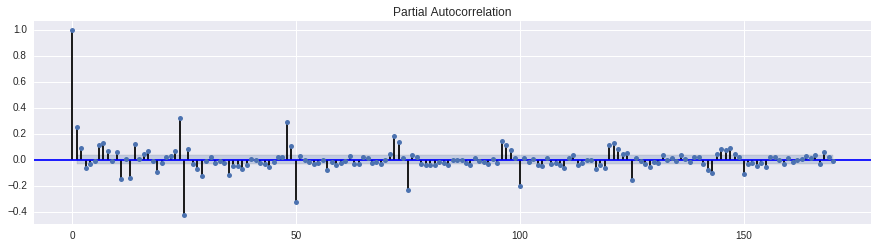

1333


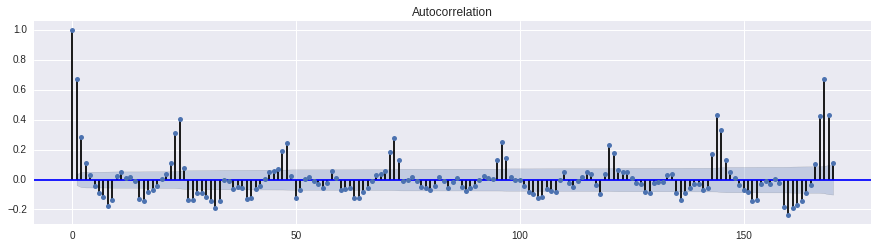

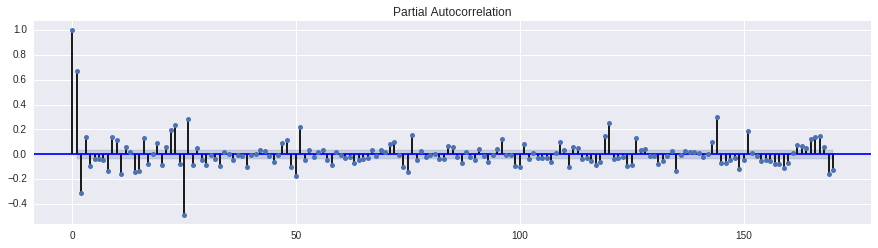

1376


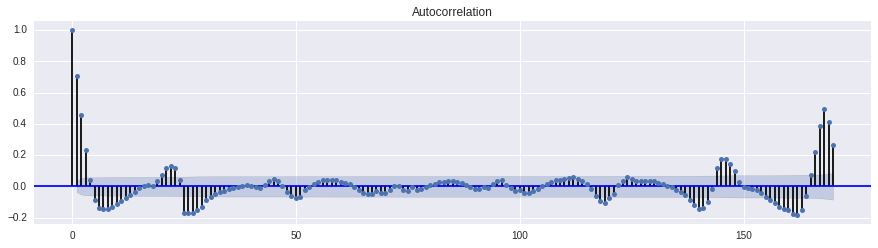

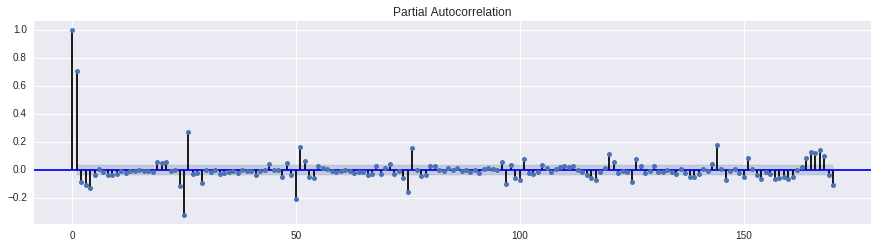

1387


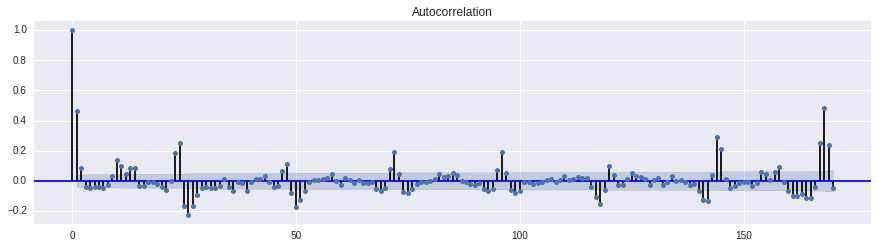

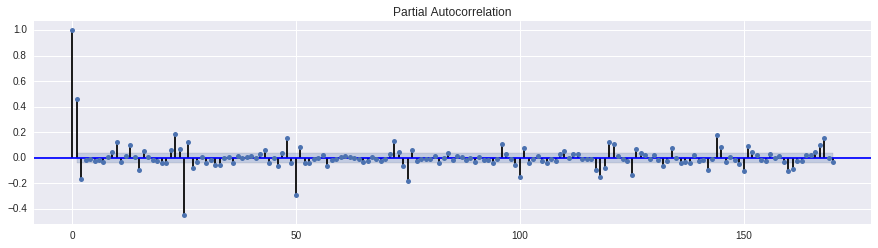

1783


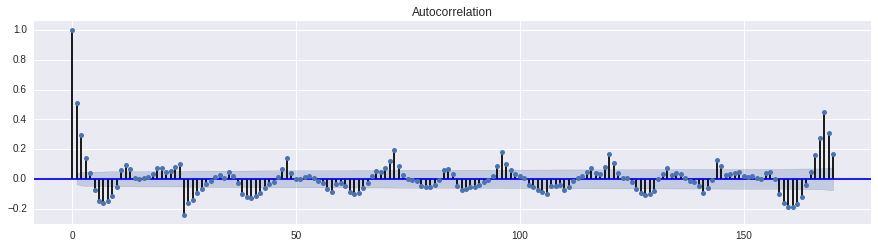

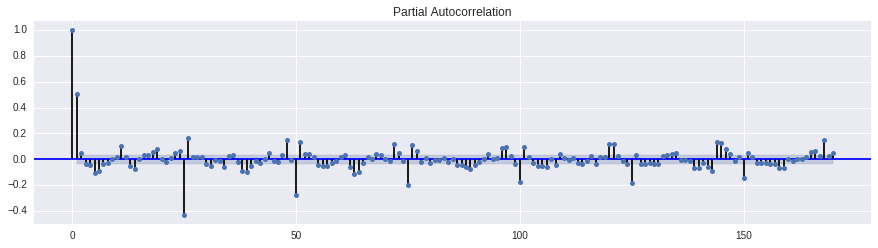

In [36]:
for row in rows:
    print row
    dff_d_h = diffs[row] - diffs[row].shift(25)
    plt.figure(figsize(15,8))
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(dff_d_h[25:], lags=170, ax=ax)
    pylab.show()
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(dff_d_h[25:], lags=170, ax=ax)
    pylab.show()

И для каждого из них подберём начальные приближения p, q, P, Q. Судя по граффикам автокорреляции и частичной автокорреляции для всех выбранных рядов можно взять Q = 1 и P = 1.

In [38]:
d = D = 1
Q = P = 3
q = p = 7

parameters_list = list(product(range(p+1), range(q+1), range(P+1), range(Q+1)))
print "Всего комбинаций параметров для каждого ряда:", len(parameters_list)

Всего комбинаций параметров для каждого ряда: 1024


Найдём лучший набор параметров для каждого ряда.

In [39]:
cluster_params = []
warnings.filterwarnings('ignore')

for row, cluster_id  in rows.iteritems():
    print "Подбираем набор параметров для ряда: ", row
    
    best_aic = float("inf")
    best_param = best_model = None
    for param in parameters_list:
        try:
            model=sm.tsa.statespace.SARIMAX(
                data[row],
                order=(param[0], d, param[1]), 
                seasonal_order=(param[2], D, param[3], 24)
            ).fit(disp=-1)
        except ValueError:
            continue
        except LinAlgError:
            continue
        aic = model.aic
    
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        
    cluster_params[cluster_id] = best_param
    
warnings.filterwarnings('default')

Подбираем набор параметров для ряда:  1177
Подбираем набор параметров для ряда:  1174
Подбираем набор параметров для ряда:  1222
Подбираем набор параметров для ряда:  1283
Подбираем набор параметров для ряда:  1233
Подбираем набор параметров для ряда:  1530
Подбираем набор параметров для ряда:  1229
Подбираем набор параметров для ряда:  2118
Подбираем набор параметров для ряда:  1333
Подбираем набор параметров для ряда:  1376
Подбираем набор параметров для ряда:  1387
Подбираем набор параметров для ряда:  1783


In [46]:
cluster_params

{0: [2, 7, 3, 3],
 1: [6, 2, 2, 3],
 2: [7, 2, 2, 3],
 3: [6, 2, 3, 3],
 4: [7, 2, 2, 2],
 5: [4, 1, 2, 3],
 6: [7, 1, 3, 3],
 7: [0, 7, 3, 3],
 8: [3, 1, 2, 3],
 9: [2, 4, 3, 3],
 10: [2, 6, 3, 3],
 11: [6, 2, 3, 3]}

# 6. Настройте модель, посчитайте ошибку прогноза для каждой зоны на данных по маю 2016
Для каждой из R географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза.

In [48]:
row_cl = {value: key for key, value in zip(cl.labels_, X.axes[1])}

In [61]:
predict = pd.DataFrame(columns=[str(_) for _ in region_list])

for row, clid in row_cl.iteritems():
    params = cluster_params[clid]
    model = sm.tsa.statespace.SARIMAX(data[row],
        order=(params[0], 1, params[1]),
        seasonal_order=(params[2], 1, params[3], 24),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=-1)
    predict[row] = model.predict(start=2904, end=2904+743)

Загрузим аггрегаты за май

In [69]:
values = pd.read_csv('regions_counts_by_hours.csv', index_col=0)
values = values[values.datetime >= '2016-05'].sort('datetime')

/srv/jupyterhub/py2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


In [75]:
values = values.drop('datetime', axis=1)

Найдём разность с предсказанием

In [79]:
diff = np.abs(predict - values)

Посчитаем ошибку прогноза:

In [97]:
sum(sum(diff[i*7:(i*7)+6].values) for i in range(125)) / (len(region_list)*739*6)

4.7855778613658755

# 7. Настройте модель, посчитайте ошибку прогноза для каждой зоны на данных по июню 2016
Для каждой из R географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

In [99]:
data = pd.read_csv('regions_counts_by_hours.csv', index_col=0)
data = data.sort('datetime')

/srv/jupyterhub/py2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


In [108]:
predict = pd.DataFrame(columns=[str(_) for _ in region_list])

for row, clid in row_cl.iteritems():
    params = cluster_params[clid]
    model = sm.tsa.statespace.SARIMAX(data[row],
        order=(params[0], 1, params[1]),
        seasonal_order=(params[2], 1, params[3], 24),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=-1)
    predict[row] = model.predict(start=3648, end=3648+720)

In [147]:
result = open('predict_for_kaggle.csv', 'w')
result.write('id,y\n')

day, hour = '2016-05-31', '23'
for i in xrange(715):
    vals = predict[i:i+6]
    for regid in region_list:
        for index, val in enumerate(vals[str(regid)]):
            result.write('{}_{}_{}_{},{}\n'.format(regid, day, hour, index+1, val))

    day, hour = vals.index[0].split(':')[0].split(' ')
    hour = str(int(hour))
result.close()